In [ ]:
import sqlite3

'''
  Getting the data from pkl files and storing it in a sqlite database
'''

'''
  Tables:
    videos: id, name, path, duration, fps, width, height
    poses: id, video_id, frame_id, category_id, score
    keypoints: id, pose_id, x, y, confidence, order
    bodies: id, x_min, y_min, width, height, idx, pose_id
    instruments: id, name, video_id 
'''

# Create a connection to the database
with sqlite3.connect('data.db') as conn:
  c = conn.cursor()
  # Create tables if they don't exist
  c.execute('''CREATE TABLE IF NOT EXISTS videos
                (id TEXT PRIMARY KEY, name TEXT, path TEXT, duration INTEGER, fps INTEGER, width INTEGER, height INTEGER)''')
  c.execute('''CREATE TABLE IF NOT EXISTS poses
                (id INTEGER PRIMARY KEY, frame_id INTEGER, category_id INTEGER, score REAL, video_id TEXT, FOREIGN KEY(video_id) REFERENCES videos(id))''')
  c.execute('''CREATE TABLE IF NOT EXISTS keypoints
                (id INTEGER PRIMARY KEY, x REAL, y REAL, confidence REAL, kp_order INTEGER, pose_id INTEGER, FOREIGN KEY(pose_id) REFERENCES poses(id))''')
  c.execute('''CREATE TABLE IF NOT EXISTS bodies
                (id INTEGER PRIMARY KEY, x_min REAL, y_min REAL, width REAL, height REAL, idx INTEGER, pose_id INTEGER, FOREIGN KEY(pose_id) REFERENCES poses(id))''')
  c.execute('''CREATE TABLE IF NOT EXISTS instruments
                (id INTEGER PRIMARY KEY, name TEXT, video_id TEXT, FOREIGN KEY(video_id) REFERENCES videos(id))''')
  conn.commit()

In [ ]:
import pickle

# Load the data from the pkl files
with open('../duet_dataset.pkl', 'rb') as f:
  duet_dataset = pickle.load(f)
duet_dataset

In [ ]:
import os
import cv2
import json

# Load the data from the pkl files to the database
with sqlite3.connect('data.db') as conn:
  c = conn.cursor()
  # Insert videos
  for folder in duet_dataset:
    for video in duet_dataset[folder]:
      input = video[0]
      output = video[1]
      instruments = video[2]
      if not os.path.exists(input) or not os.path.exists(output):
        continue
      name = os.path.basename(input)
      path = input
      duration = cv2.VideoCapture(input).get(cv2.CAP_PROP_FRAME_COUNT)
      fps = cv2.VideoCapture(input).get(cv2.CAP_PROP_FPS)
      width = cv2.VideoCapture(input).get(cv2.CAP_PROP_FRAME_WIDTH)
      height = cv2.VideoCapture(input).get(cv2.CAP_PROP_FRAME_HEIGHT)
      c.execute('''INSERT OR IGNORE INTO videos (id, name, path, duration, fps, width, height)
                    VALUES (?, ?, ?, ?, ?, ?, ?)''', (name, name, path, duration, fps, width, height))
      # Insert instruments
      for instrument in instruments:
        c.execute('''INSERT OR IGNORE INTO instruments (name, video_id)
                      VALUES (?, ?)''', (instrument, name))
      print('Inserted video: ', name, duration, fps, width, height)
      # Insert poses
      with open(output, 'rb') as f:
        # Load json output
        poses = json.load(f)
        # Insert poses
        for pose in poses:
          frame_id = pose['image_id']
          category_id = pose['category_id']
          score = pose['score']
          c.execute('''INSERT OR IGNORE INTO poses (frame_id, category_id, score, video_id)
                        VALUES (?, ?, ?, ?)''', (frame_id, category_id, score, name))
          # print('Inserted pose:', frame_id, category_id, score, name)
          # Insert keypoints
          keypoints = pose['keypoints']
          num_joints = int(len(keypoints) / 3)
          pose_id = c.lastrowid
          for j in range(num_joints):
              #Get the x and y coordinates of the joints
              x = keypoints[j*3]
              y = keypoints[j*3+1]
              confidence = keypoints[j*3+2]
              kp_order = j
              c.execute('''INSERT OR IGNORE INTO keypoints (x, y, confidence, kp_order, pose_id)
                            VALUES (?, ?, ?, ?, ?)''', (x, y, confidence, kp_order, pose_id))
          # print('Joints num: ', num_joints)
          x_min = pose['box'][0]
          y_min = pose['box'][1]
          width = pose['box'][2]
          height = pose['box'][3]
          idx = pose['idx']
          c.execute('''INSERT OR IGNORE INTO bodies (x_min, y_min, width, height, pose_id)
                        VALUES (?, ?, ?, ?, ?)''', (x_min, y_min, width, height, idx, pose_id))
          # print('Box: ', x_min, y_min, width, height)
      conn.commit()

In [1]:
import pickle

# Load the data from the pkl files
with open('../solo_dataset.pkl', 'rb') as f:
  solo_dataset = pickle.load(f)
solo_dataset

{'accordion': [['/ext_data2/manhnh/MUSIC_dataset/output/MUSIC_solo2/accordion/0N26WnKiCIg_0.mp4',
   '/home/manhnguyen/new/AlphaPose-MUSIC-Test/solo-results/0N26WnKiCIg_0.json',
   ['accordion']],
  ['/ext_data2/manhnh/MUSIC_dataset/output/MUSIC_solo2/accordion/0N26WnKiCIg_10.mp4',
   '/home/manhnguyen/new/AlphaPose-MUSIC-Test/solo-results/0N26WnKiCIg_10.json',
   ['accordion']],
  ['/ext_data2/manhnh/MUSIC_dataset/output/MUSIC_solo2/accordion/0N26WnKiCIg_11.mp4',
   '/home/manhnguyen/new/AlphaPose-MUSIC-Test/solo-results/0N26WnKiCIg_11.json',
   ['accordion']],
  ['/ext_data2/manhnh/MUSIC_dataset/output/MUSIC_solo2/accordion/0N26WnKiCIg_12.mp4',
   '/home/manhnguyen/new/AlphaPose-MUSIC-Test/solo-results/0N26WnKiCIg_12.json',
   ['accordion']],
  ['/ext_data2/manhnh/MUSIC_dataset/output/MUSIC_solo2/accordion/0N26WnKiCIg_1.mp4',
   '/home/manhnguyen/new/AlphaPose-MUSIC-Test/solo-results/0N26WnKiCIg_1.json',
   ['accordion']],
  ['/ext_data2/manhnh/MUSIC_dataset/output/MUSIC_solo2/accord

In [5]:
# Convert into list of dicts where each dict is a json file with: has_skeleton, label, and label_index
import json
import sqlite3

instruments = []
labels = {}
for instrument in solo_dataset:
  if instrument not in instruments:
    instruments.append(instrument)
    index = len(instruments) - 1
  else:
    index = instruments.index(instrument)
  for data in solo_dataset[instrument]:
    video_id = os.path.basename(data[0])
    # Check if the json file has a skeleton
    has_skeleton = True
    with sqlite3.connect('data.db') as conn:
      c = conn.cursor()
      c.execute('''SELECT id FROM videos WHERE id = ? AND id IN (SELECT video_id FROM poses)''', (video_id,))
      video_id = c.fetchone()
      if video_id is None:
        has_skeleton = False
    json_id = os.path.basename(data[1])
    labels[json_id] = {'has_skeleton': has_skeleton, 'label': instrument, 'label_index': index}
instruments

['accordion',
 'acoustic_guitar',
 'cello',
 'clarinet',
 'erhu',
 'flute',
 'saxophone',
 'trumpet',
 'tuba',
 'violin',
 'xylophone']

In [8]:
# Create train, val, and test splits with the labels
import random

train_split = 0.8
val_split = 0.1
test_split = 0.1

train_labels = {}
val_labels = {}
test_labels = {}

train_json = "music_solo_train.json"
val_json = "music_solo_val.json"
test_json = "music_solo_test.json"

for instrument in instruments:
  instrument_labels = {k: v for k, v in labels.items() if v['label'] == instrument}
  keys = list(instrument_labels.keys())
  random.shuffle(keys)
  train_keys = keys[:int(len(keys) * train_split)]
  val_keys = keys[int(len(keys) * train_split):int(len(keys) * (train_split + val_split))]
  test_keys = keys[int(len(keys) * (train_split + val_split)):]
  for key in train_keys:
    train_labels[key] = instrument_labels[key]
  for key in val_keys:
    val_labels[key] = instrument_labels[key]
  for key in test_keys:
    test_labels[key] = instrument_labels[key]
    
# Re-shuffle the labels and write them to json files
import json

json.dump(train_labels, open(train_json, 'w'))
json.dump(val_labels, open(val_json, 'w'))
json.dump(test_labels, open(test_json, 'w'))

In [11]:
import os

jsons_path = '/ext_data2/manhnh/alphapose-solo-results'
os.chdir(jsons_path)

train_folder = 'music_solo_train'
val_folder = 'music_solo_val'
test_folder = 'music_solo_test'

# Create folders
if not os.path.exists(train_folder):
  os.makedirs(train_folder)
if not os.path.exists(val_folder):
  os.makedirs(val_folder)
if not os.path.exists(test_folder):
  os.makedirs(test_folder)

# Move the json files to the folders
for json_file in os.listdir(jsons_path):
  if json_file in train_labels:
    os.rename(os.path.join(jsons_path, json_file), os.path.join(jsons_path, train_folder, json_file))
  elif json_file in val_labels:
    os.rename(os.path.join(jsons_path, json_file), os.path.join(jsons_path, val_folder, json_file))
  elif json_file in test_labels:
    os.rename(os.path.join(jsons_path, json_file), os.path.join(jsons_path, test_folder, json_file))

In [2]:
import os
import cv2
import json

# Load the data from the pkl files to the database
with sqlite3.connect('data.db') as conn:
  c = conn.cursor()
  # Insert videos
  for folder in solo_dataset:
    for video in solo_dataset[folder]:
      input = video[0]
      output = video[1]
      instruments = video[2]
      if not os.path.exists(input) or not os.path.exists(output):
        continue
      name = os.path.basename(input)
      path = input
      duration = cv2.VideoCapture(input).get(cv2.CAP_PROP_FRAME_COUNT)
      fps = cv2.VideoCapture(input).get(cv2.CAP_PROP_FPS)
      width = cv2.VideoCapture(input).get(cv2.CAP_PROP_FRAME_WIDTH)
      height = cv2.VideoCapture(input).get(cv2.CAP_PROP_FRAME_HEIGHT)
      c.execute('''INSERT OR IGNORE INTO videos (id, name, path, duration, fps, width, height)
                    VALUES (?, ?, ?, ?, ?, ?, ?)''', (name, name, path, duration, fps, width, height))
      # Insert instruments
      for instrument in instruments:
        c.execute('''INSERT OR IGNORE INTO instruments (name, video_id)
                      VALUES (?, ?)''', (instrument, name))
      print('Inserted video: ', name, duration, fps, width, height)
      # Insert poses
      with open(output, 'rb') as f:
        # Load json output
        poses = json.load(f)
        # Insert poses
        for pose in poses:
          frame_id = pose['image_id']
          category_id = pose['category_id']
          score = pose['score']
          c.execute('''INSERT OR IGNORE INTO poses (frame_id, category_id, score, video_id)
                        VALUES (?, ?, ?, ?)''', (frame_id, category_id, score, name))
          # print('Inserted pose:', frame_id, category_id, score, name)
          # Insert keypoints
          keypoints = pose['keypoints']
          num_joints = int(len(keypoints) / 3)
          pose_id = c.lastrowid
          for j in range(num_joints):
              #Get the x and y coordinates of the joints
              x = keypoints[j*3]
              y = keypoints[j*3+1]
              confidence = keypoints[j*3+2]
              kp_order = j
              c.execute('''INSERT OR IGNORE INTO keypoints (x, y, confidence, kp_order, pose_id)
                            VALUES (?, ?, ?, ?, ?)''', (x, y, confidence, kp_order, pose_id))
          # print('Joints num: ', num_joints)
          x_min = pose['box'][0]
          y_min = pose['box'][1]
          width = pose['box'][2]
          height = pose['box'][3]
          idx = pose['idx']
          c.execute('''INSERT OR IGNORE INTO bodies (x_min, y_min, width, height, idx, pose_id)
                        VALUES (?, ?, ?, ?, ?, ?)''', (x_min, y_min, width, height, idx, pose_id))
          # print('Box: ', x_min, y_min, width, height)
      conn.commit()

NameError: name 'sqlite3' is not defined

In [ ]:
import sqlite3
# Create index on poses table using the video_id and frame_id
with sqlite3.connect('data.db') as conn:
  c = conn.cursor()
  # Delete the index if it exists
  c.execute('''DROP INDEX IF EXISTS poses_video_id_frame_id''')
  c.execute('''CREATE INDEX poses_video_id_frame_id ON poses(video_id, frame_id)''')
  conn.commit()

In [1]:
import sqlite3
# Get the number of bodies in a video
video_bodies = {}
with sqlite3.connect('data.db') as conn:
  c = conn.cursor()
  # Count the number of unique idx of the bodies table
  c.execute('''SELECT video_id, COUNT(DISTINCT idx) FROM bodies JOIN poses ON bodies.pose_id = poses.id GROUP BY video_id''')
  for row in c:
    video_bodies[row[0]] = row[1]
video_bodies

{'--IXKwloYLE_0.mp4': 2,
 '--IXKwloYLE_1.mp4': 2,
 '--IXKwloYLE_10.mp4': 2,
 '--IXKwloYLE_2.mp4': 2,
 '--IXKwloYLE_3.mp4': 2,
 '--IXKwloYLE_4.mp4': 2,
 '--IXKwloYLE_5.mp4': 3,
 '--IXKwloYLE_6.mp4': 3,
 '--IXKwloYLE_7.mp4': 2,
 '--IXKwloYLE_8.mp4': 2,
 '--IXKwloYLE_9.mp4': 2,
 '-0gYWIOfqdM_0.mp4': 1,
 '-0gYWIOfqdM_1.mp4': 1,
 '-0gYWIOfqdM_2.mp4': 2,
 '-0gYWIOfqdM_4.mp4': 1,
 '-0gYWIOfqdM_6.mp4': 3,
 '-0gYWIOfqdM_7.mp4': 1,
 '-3V-vUMkHqk_0.mp4': 1,
 '-3V-vUMkHqk_1.mp4': 4,
 '-5CDUnGu3jA_0.mp4': 4,
 '-5CDUnGu3jA_1.mp4': 3,
 '-5CDUnGu3jA_10.mp4': 3,
 '-5CDUnGu3jA_11.mp4': 3,
 '-5CDUnGu3jA_12.mp4': 1,
 '-5CDUnGu3jA_13.mp4': 5,
 '-5CDUnGu3jA_14.mp4': 2,
 '-5CDUnGu3jA_15.mp4': 2,
 '-5CDUnGu3jA_16.mp4': 2,
 '-5CDUnGu3jA_17.mp4': 6,
 '-5CDUnGu3jA_18.mp4': 4,
 '-5CDUnGu3jA_19.mp4': 4,
 '-5CDUnGu3jA_2.mp4': 2,
 '-5CDUnGu3jA_3.mp4': 1,
 '-5CDUnGu3jA_4.mp4': 4,
 '-5CDUnGu3jA_5.mp4': 2,
 '-5CDUnGu3jA_6.mp4': 3,
 '-5CDUnGu3jA_7.mp4': 2,
 '-5CDUnGu3jA_8.mp4': 1,
 '-5CDUnGu3jA_9.mp4': 6,
 '-5MipMQ25cU_

In [5]:
import sqlite3
# Get the number of bodies in a video
video_bodies_solo = {}
with sqlite3.connect('data.db') as conn:
  c = conn.cursor()
  # Count the number of unique idx of the bodies table
  c.execute('''SELECT video_id, COUNT(DISTINCT idx) FROM bodies JOIN poses ON bodies.pose_id = poses.id
            WHERE video_id IN (SELECT video_id FROM instruments GROUP BY video_id HAVING COUNT(id) = 1) GROUP BY video_id''')
  for row in c:
    video_bodies_solo[row[0]] = row[1]
video_bodies_solo, len(video_bodies_solo)

({'-0gYWIOfqdM_0.mp4': 1,
  '-0gYWIOfqdM_1.mp4': 1,
  '-0gYWIOfqdM_2.mp4': 2,
  '-0gYWIOfqdM_4.mp4': 1,
  '-0gYWIOfqdM_6.mp4': 3,
  '-0gYWIOfqdM_7.mp4': 1,
  '-3V-vUMkHqk_0.mp4': 1,
  '-3V-vUMkHqk_1.mp4': 4,
  '-5CDUnGu3jA_0.mp4': 4,
  '-5CDUnGu3jA_1.mp4': 3,
  '-5CDUnGu3jA_10.mp4': 3,
  '-5CDUnGu3jA_11.mp4': 3,
  '-5CDUnGu3jA_12.mp4': 1,
  '-5CDUnGu3jA_13.mp4': 5,
  '-5CDUnGu3jA_14.mp4': 2,
  '-5CDUnGu3jA_15.mp4': 2,
  '-5CDUnGu3jA_16.mp4': 2,
  '-5CDUnGu3jA_17.mp4': 6,
  '-5CDUnGu3jA_18.mp4': 4,
  '-5CDUnGu3jA_19.mp4': 4,
  '-5CDUnGu3jA_2.mp4': 2,
  '-5CDUnGu3jA_3.mp4': 1,
  '-5CDUnGu3jA_4.mp4': 4,
  '-5CDUnGu3jA_5.mp4': 2,
  '-5CDUnGu3jA_6.mp4': 3,
  '-5CDUnGu3jA_7.mp4': 2,
  '-5CDUnGu3jA_8.mp4': 1,
  '-5CDUnGu3jA_9.mp4': 6,
  '-5MipMQ25cU_0.mp4': 1,
  '-5MipMQ25cU_1.mp4': 1,
  '-5MipMQ25cU_10.mp4': 3,
  '-5MipMQ25cU_11.mp4': 1,
  '-5MipMQ25cU_2.mp4': 1,
  '-5MipMQ25cU_3.mp4': 1,
  '-5MipMQ25cU_4.mp4': 4,
  '-5MipMQ25cU_5.mp4': 1,
  '-5MipMQ25cU_6.mp4': 1,
  '-5MipMQ25cU_7.mp4': 1,


In [ ]:
for video in video_bodies.keys():
    if video_bodies[video] == 558:
        print(video)

In [ ]:
import sqlite3
# Get the video that have no poses
with sqlite3.connect('data.db') as conn:
  c = conn.cursor()
  # Count the number of unique idx of the bodies table
  c.execute('''SELECT id FROM videos WHERE id NOT IN (SELECT video_id FROM poses)''')
  for row in c:
    print(row[0])

In [ ]:
# Display the results into a pie graph and save it
import matplotlib.pyplot as plt
import numpy as np

def plot_pie(video_bodies):
  # Create a pie chart compose of videos with 1, 2, 3, and >3 bodies
  labels = ['1', '2', '3', '>3']
  # Split the videos into groups of 1, 2, 3, and >3 video_bodies
  sizes = [0, 0, 0, 0]
  for video in video_bodies:
    if video_bodies[video] == 1:
      sizes[0] += 1
    elif video_bodies[video] == 2:
      sizes[1] += 1
    elif video_bodies[video] == 3:
      sizes[2] += 1
    else:
      sizes[3] += 1
  colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
  explode = (0.0, 0.2, 0.0, 0.0)
  plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
  plt.axis('equal')
  plt.savefig('../duet_dataset_pie.png')
  plt.show()

plot_pie(video_bodies)

In [ ]:
# Display the results into a bar graph and save it
import matplotlib.pyplot as plt
import numpy as np

def plot_bar(video_bodies):
  # Create a bar chart compose from the least amount of bodies to the most amount of bodies
  x = np.arange(len(video_bodies))
  y = video_bodies.values()
  bars = {}
  for val in y:
    if val not in bars:
      bars[val] = 1
    else:
      bars[val] += 1
  plt.bar(*zip(*bars.items()))
  # Limit the x axis to the max number of bodies
  plt.xlim(0, 60)
  plt.show()

plot_bar(video_bodies)

In [ ]:
# Display a random sample of the frames with >2 bodies
import random, cv2

def display_random_sample(video_bodies):
  larger_than_2_bodies = []
  with sqlite3.connect('data.db') as conn:
    c = conn.cursor()
    # Get the frames with >2 bodies
    c.execute('''SELECT pose_id, frame_id FROM poses JOIN bodies ON poses.id = bodies.pose_id GROUP BY video_id, frame_id HAVING COUNT(DISTINCT pose_id) > 2''')
    for row in c:
      larger_than_2_bodies.append(row)
  # Get a random sample of the frames with >2 bodies
  random_sample = random.sample(larger_than_2_bodies, 9)
  # plt a grid of num_of_samples frames with >2 bodies
  fig, ax = plt.subplots(3,3)
  for i, row in enumerate(random_sample):
    pose_id = row[0]
    frame_id = int(row[1][:-4])
    # Get the image
    # Get the path and video_id first
    c.execute('''SELECT path, video_id FROM videos JOIN poses ON videos.id = poses.video_id WHERE poses.id = ?''', (pose_id,))
    video_path, video_id = c.fetchone()
    # Get the frame_id-th frame of the video
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
    ret, frame = cap.read()
    # Draw the bodies' bounding boxes on the frame
    c.execute('''SELECT x_min, y_min, width, height FROM bodies JOIN poses ON bodies.pose_id = poses.id WHERE video_id = ? AND frame_id = ?''', (video_id, row[1]))
    for r in c:
      x_min = int(r[0])
      y_min = int(r[1])
      width = int(r[2])
      height = int(r[3])
      cv2.rectangle(frame, (x_min, y_min), (x_min+width, y_min+height), (0, 255, 0), 2)
    #  Show the images with the frame_id in the fig
    ax[i//3, i%3].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    ax[i//3, i%3].set_title(str(os.path.basename(video_path))[:-4])
    ax[i//3, i%3].axis('off')
  plt.savefig('../duet_dataset_sample.png', dpi = 300)
  plt.show()

display_random_sample(video_bodies)

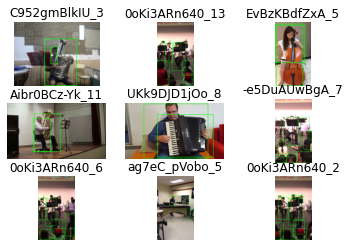

In [9]:
# Display a random sample of the frames with >2 bodies
import random, cv2
import matplotlib.pyplot as plt

def display_random_sample_solo(video_bodies_solo):
  larger_than_1_bodies = []
  with sqlite3.connect('data.db') as conn:
    c = conn.cursor()
    # Get the frames with >1 bodies
    c.execute('''SELECT pose_id, frame_id, video_id FROM poses JOIN bodies ON poses.id = bodies.pose_id GROUP BY video_id, frame_id HAVING COUNT(DISTINCT pose_id) > 1''')
    for row in c:
      if row[2] in video_bodies_solo:
        larger_than_1_bodies.append(row)
  # Get a random sample of the frames with >1 bodies
  random_sample = random.sample(larger_than_1_bodies, 9)
  # plt a grid of num_of_samples frames with >1 bodies
  fig, ax = plt.subplots(3,3)
  for i, row in enumerate(random_sample):
    pose_id = row[0]
    frame_id = int(row[1][:-4])
    # Get the image
    # Get the path and video_id first
    c.execute('''SELECT path, video_id FROM videos JOIN poses ON videos.id = poses.video_id WHERE poses.id = ?''', (pose_id,))
    video_path, video_id = c.fetchone()
    # Get the frame_id-th frame of the video
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
    ret, frame = cap.read()
    # Draw the bodies' bounding boxes on the frame
    c.execute('''SELECT x_min, y_min, width, height FROM bodies JOIN poses ON bodies.pose_id = poses.id WHERE video_id = ? AND frame_id = ?''', (video_id, row[1]))
    for r in c:
      x_min = int(r[0])
      y_min = int(r[1])
      width = int(r[2])
      height = int(r[3])
      cv2.rectangle(frame, (x_min, y_min), (x_min+width, y_min+height), (0, 255, 0), 2)
    #  Show the images with the frame_id in the fig
    ax[i//3, i%3].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    ax[i//3, i%3].set_title(str(os.path.basename(video_path))[:-4])
    ax[i//3, i%3].axis('off')
  plt.savefig('../solo_dataset_sample.png', dpi = 300)
  plt.show()

display_random_sample_solo(video_bodies_solo)

In [12]:
# Get the two most common idx of the bodies table for each video
import sqlite3

idx_count = {}
with sqlite3.connect('data.db') as conn:
  c = conn.cursor()
  # Get the two most common idx of the bodies table for each video, also the number of instruments
  c.execute('''SELECT video_id, idx, COUNT(idx) FROM bodies JOIN poses ON bodies.pose_id = poses.id GROUP BY video_id, idx ORDER BY video_id, COUNT(idx) DESC''')
  for row in c:
    if row[0] not in idx_count:
      idx_count[row[0]] = {}
    idx_count[row[0]][row[1]] = row[2]
len(idx_count)

8754

In [13]:
# Get the count of instruments per video
import sqlite3

with sqlite3.connect('data.db') as conn:
  c = conn.cursor()
  # Get the count of instruments per video
  c.execute('''SELECT video_id, COUNT(id) FROM instruments GROUP BY video_id''')
  for row in c:
    if row[0] not in idx_count:
      idx_count[row[0]] = {}
    idx_count[row[0]]['instruments'] = row[1]
len(idx_count)

8820

In [18]:
import sqlite3

'''
Get the count and size sum of each idx
'''
idx_size_count = {}

with sqlite3.connect('data.db') as conn:
  c = conn.cursor()
  c.execute('''SELECT video_id, idx, COUNT(idx), SUM(width*height) FROM bodies JOIN poses ON bodies.pose_id = poses.id GROUP BY video_id, idx''')
  for row in c:
    if row[0] not in idx_size_count:
      idx_size_count[row[0]] = {}
    if row[1] not in idx_size_count[row[0]]:
      idx_size_count[row[0]][row[1]] = {}
    idx_size_count[row[0]][row[1]]['count'] = row[2]
    idx_size_count[row[0]][row[1]]['size'] = row[3]

  # Get the count of instruments per video
  c.execute('''SELECT video_id, COUNT(id) FROM instruments GROUP BY video_id''')
  for row in c:
    if row[0] not in idx_size_count:
      idx_size_count[row[0]] = {}
    idx_size_count[row[0]]['instruments'] = row[1]
len(idx_size_count)

8820

In [19]:
idx_size_count

{'--IXKwloYLE_0.mp4': {1: {'count': 189, 'size': 11330913.403301533},
  2: {'count': 185, 'size': 10273480.128186217},
  'instruments': 2},
 '--IXKwloYLE_1.mp4': {1: {'count': 198, 'size': 12633028.29776723},
  2: {'count': 198, 'size': 10373169.734423235},
  'instruments': 2},
 '--IXKwloYLE_10.mp4': {1: {'count': 192, 'size': 11415000.70449492},
  2: {'count': 195, 'size': 11282781.138013829},
  'instruments': 2},
 '--IXKwloYLE_2.mp4': {1: {'count': 246, 'size': 15650358.919318594},
  2: {'count': 246, 'size': 13204910.241508894},
  'instruments': 2},
 '--IXKwloYLE_3.mp4': {1: {'count': 232, 'size': 14414795.599646633},
  2: {'count': 232, 'size': 12217501.350313298},
  'instruments': 2},
 '--IXKwloYLE_4.mp4': {1: {'count': 240, 'size': 15439406.917334342},
  2: {'count': 240, 'size': 13174710.713629745},
  'instruments': 2},
 '--IXKwloYLE_5.mp4': {1: {'count': 228, 'size': 14521580.552902544},
  2: {'count': 228, 'size': 12232014.485233728},
  3: {'count': 1, 'size': 2995.14815032482

In [33]:
# Display a random sample of the frames with >2 bodies
import random, cv2
import matplotlib.pyplot as plt

def display_random_sample_solo(video_bodies_solo):
  larger_than_1_bodies = []
  with sqlite3.connect('data.db') as conn:
    c = conn.cursor()
    # Get the frames with >1 bodies
    c.execute('''SELECT pose_id, frame_id, video_id FROM poses JOIN bodies ON poses.id = bodies.pose_id GROUP BY video_id, frame_id HAVING COUNT(DISTINCT pose_id) > 1''')
    for row in c:
      if row[2] in video_bodies_solo:
        larger_than_1_bodies.append(row)
  # Get a random sample of the frames with >1 bodies
  random_sample = random.sample(larger_than_1_bodies, 9)
  # plt a grid of num_of_samples frames with >1 bodies
  fig, ax = plt.subplots(3,3)
  for i, row in enumerate(random_sample):
    pose_id = row[0]
    frame_id = int(row[1][:-4])
    # Get the image
    # Get the path and video_id first
    c.execute('''SELECT path, video_id FROM videos JOIN poses ON videos.id = poses.video_id WHERE poses.id = ?''', (pose_id,))
    video_path, video_id = c.fetchone()
    # Get the frame_id-th frame of the video
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
    ret, frame = cap.read()
    # Draw the bodies' bounding boxes on the frame
    c.execute('''SELECT x_min, y_min, width, height, idx FROM bodies JOIN poses ON bodies.pose_id = poses.id WHERE video_id = ? AND frame_id = ?''', (video_id, row[1]))
    for r in c:
      x_min = int(r[0])
      y_min = int(r[1])
      width = int(r[2])
      height = int(r[3])
      idx = int(r[4])
      cv2.rectangle(frame, (x_min, y_min), (x_min+width, y_min+height), (0, 255, 0), 2)
      # Annotate the bounding box with the count and sizes of each idx from idx_size_count
      cv2.putText(frame, str(int(float(idx_size_count[video_id][idx]['size'])/1000)), (x_min+int(width/2), y_min+int(height/2)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    #  Show the images with the frame_id in the fig
    ax[i//3, i%3].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    ax[i//3, i%3].set_title(str(os.path.basename(video_path))[:-4])
    ax[i//3, i%3].axis('off')
  plt.savefig('../annotated_solo_dataset_sample.png', dpi = 300)
  plt.show()

display_random_sample_solo(video_bodies_solo)

[1, 2, 'other']
[2459.159014984486, 553.7362133750114, 179.10477164050832]


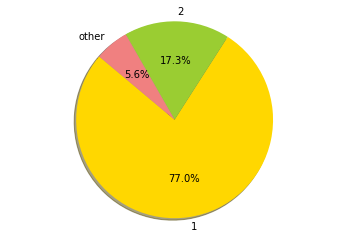

In [32]:
# Plot a pie graph showing the percentage
# of each idx appearences per video
import matplotlib.pyplot as plt
import numpy as np

def plot_appearences(idx_count, compare_to):
  idx_count_more = {}
  for video in idx_count:
    if idx_count[video]['instruments'] == compare_to and (compare_to + 1) in idx_count[video]:
      idx_count_more[video] = idx_count[video]
  percentages = {}
  for video in idx_count_more:
    # Sort the idx by the number of appearences
    sorted_idx = [x for x in idx_count_more[video] if x != 'instruments']
    sorted_idx = sorted(sorted_idx, key=lambda x: idx_count_more[video][x], reverse=True)
    percentages[video] = {}
    total = sum(idx_count_more[video].values()) - idx_count_more[video]['instruments']
    other_total = 0
    for idx in sorted_idx:  
      # Sum of all the idx appearences
      if sorted_idx.index(idx) <= compare_to:
        percentages[video][sorted_idx.index(idx) + 1] = idx_count[video][idx] / total
      else:
        other_total += idx_count[video][idx]
    percentages[video]['other'] = other_total / total
  # Create a pie chart compose from the least amount of idx to the most amount of idx
  labels = [x for x in range(1, compare_to + 2)] + ['other']
  sizes = []
  for l in labels:
    sizes.append(sum([percentages[video][l] for video in percentages]))
  print(labels)
  print(sizes)
  colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
  plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
  plt.axis('equal')
  plt.savefig('../appearences_pie.png')
  plt.show()

plot_appearences(idx_count, 1)

In [4]:
# Get the poses and the sizes of the bodies
import sqlite3

bodies = {}
with sqlite3.connect('data.db') as conn:
  c = conn.cursor()
  # Get the poses and the sizes of the bodies
  c.execute('''SELECT idx, video_id, frame_id, x_min, y_min, width, height FROM bodies JOIN poses ON bodies.pose_id = poses.id''')
  bodies = {}
  for row in c:
    id = row[1][:-4]
    if id not in bodies:
      bodies[id] = {}
    if row[2] not in bodies[id]:
      bodies[id][row[2]] = {}
    bodies[id][row[2]][row[0]] = {'x_min': row[3], 'y_min': row[4], 'width': row[5], 'height': row[6], 'area': row[5] * row[6]}
len(bodies)

8754

In [8]:
# Get random 1000 videos from bodies
import random

bodies = {k: bodies[k] for k in random.sample(list(bodies), 1000)}

In [5]:
# Get the total area of the bodies for each video
idx_sizes = {} 
for video in bodies:
  video_idx = [y for x in bodies[video] for y in bodies[video][x]]
  video_idx = list(set(video_idx))
  idx_sizes[video] = {}
  for idx in video_idx:
    idx_sizes[video][idx] = sum([bodies[video][frame][idx]['area'] for frame in bodies[video] if idx in bodies[video][frame]])
len(idx_sizes)

8754

In [6]:
# Get the count of instruments per video
import sqlite3

with sqlite3.connect('data.db') as conn:
  c = conn.cursor()
  # Get the count of instruments per video
  c.execute('''SELECT video_id, COUNT(id) FROM instruments GROUP BY video_id''')
  for row in c:
    if row[0][:-4] not in idx_sizes:
      idx_sizes[row[0][:-4]] = {}
    idx_sizes[row[0][:-4]]['instruments'] = row[1]
len(idx_sizes)

8820

In [7]:
idx_sizes

{'1uG4jnhHgAc_0': {1: 21110348.34222688,
  2: 22268274.19986234,
  3: 156673.9953835181,
  'instruments': 2},
 '1uG4jnhHgAc_10': {1: 16582426.850732822,
  2: 20109397.79202781,
  'instruments': 2},
 '1uG4jnhHgAc_11': {1: 15414879.369643047,
  2: 18070093.903925914,
  3: 138234.3310546875,
  'instruments': 2},
 '1uG4jnhHgAc_12': {1: 16833932.875943366,
  2: 18452843.946370233,
  'instruments': 2},
 '1uG4jnhHgAc_13': {1: 20654513.857698083,
  2: 22744632.79420376,
  3: 24527.68317612447,
  'instruments': 2},
 '1uG4jnhHgAc_14': {1: 19171435.742952544,
  2: 19835926.792109426,
  'instruments': 2},
 '1uG4jnhHgAc_15': {1: 20418097.862302035,
  2: 21040484.861683786,
  3: 29956.607693163678,
  'instruments': 2},
 '1uG4jnhHgAc_16': {1: 20329032.392618157,
  2: 19930197.178946506,
  'instruments': 2},
 '1uG4jnhHgAc_17': {1: 18865881.0947255,
  2: 21978913.37216665,
  'instruments': 2},
 '1uG4jnhHgAc_18': {1: 19417200.929663643,
  2: 21564324.963969603,
  'instruments': 2},
 '1uG4jnhHgAc_19': {1